In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from scipy.optimize import curve_fit
from matplotlib.ticker import MaxNLocator, AutoMinorLocator
from scipy.signal import correlate
import pandas as pd
from scipy.interpolate import griddata

In [3]:
# ---------------- USER-CONTROLLED RANGES ----------------
l1_ang_min = 0.2
l1_ang_max = 1.2
Nl1 = 12

l2_ang_min = 0.3
l2_ang_max = 1.5
Nl2 = 12

E_eV = 5.0   # electron energy (fixed)
# -------------------------------------------------------

# -----------------------------
# Physical constants (SI)
# -----------------------------
e    = 1.602176634e-19      # J/eV
m_e  = 9.10938356e-31       # kg
hbar = 1.054571817e-34      # J*s

# -----------------------------
# Helpers: k(E, V) and matrices
# -----------------------------
def k_of(E_J, V_J):
    """Wave number k = sqrt(2m(E-V))/hbar with complex handling for E<V."""
    return np.sqrt(2 * m_e * (E_J - V_J) + 0j) / hbar

def interface_matrix(k_left, k_right):
    """
    Interface matrix I_{L->R} for same effective mass:
    [A_L; B_L] = I [A_R; B_R]
    """
    ratio = k_right / k_left
    return 0.5 * np.array([[1 + ratio, 1 - ratio],
                           [1 - ratio, 1 + ratio]], dtype=complex)

def propagation_matrix(k, L):
    """Propagation matrix through length L in a region with wave number k."""
    return np.array([[np.exp(1j * k * L), 0],
                     [0, np.exp(-1j * k * L)]], dtype=complex)

def matmul2(A, B):
    """2x2 matrix multiply."""
    return A @ B

# -----------------------------
# Transmission through asymmetric double barrier
# -----------------------------
def T_double_barrier_asym(E_eV, V1_eV, l1_m, V2_eV, l2_m, d_m):
    """
    Transmission probability for:
      V=0 | barrier(V1,l1) | well(0,d) | barrier(V2,l2) | V=0

    E_eV can be scalar or numpy array.
    """
    E_eV = np.asarray(E_eV, dtype=float)
    E_J  = E_eV * e

    V0_J = 0.0
    V1_J = V1_eV * e
    V2_J = V2_eV * e
    V4_J = 0.0

    # Wave numbers in each region (vectorized over E)
    k0 = k_of(E_J, V0_J)
    k1 = k_of(E_J, V1_J)
    k2 = k_of(E_J, 0.0)
    k3 = k_of(E_J, V2_J)
    k4 = k_of(E_J, V4_J)

    # Avoid division by zero at E -> V (rare but can happen numerically)
    eps = 1e-300 + 0j
    k0 = np.where(np.abs(k0) == 0, eps, k0)
    k1 = np.where(np.abs(k1) == 0, eps, k1)
    k2 = np.where(np.abs(k2) == 0, eps, k2)
    k3 = np.where(np.abs(k3) == 0, eps, k3)
    k4 = np.where(np.abs(k4) == 0, eps, k4)

    T = np.empty_like(E_eV, dtype=float)

    # Build and evaluate transfer matrix per-energy (simple + robust)
    for i in range(E_eV.size):
        I01 = interface_matrix(k0[i], k1[i])
        P1  = propagation_matrix(k1[i], l1_m)
        I12 = interface_matrix(k1[i], k2[i])
        P2  = propagation_matrix(k2[i], d_m)
        I23 = interface_matrix(k2[i], k3[i])
        P3  = propagation_matrix(k3[i], l2_m)
        I34 = interface_matrix(k3[i], k4[i])

        M = matmul2(I01, matmul2(P1, matmul2(I12, matmul2(P2, matmul2(I23, matmul2(P3, I34))))))

        # Left incidence: t = 1 / M00, and flux factor k4/k0 if leads differ
        t = 1.0 / M[0, 0]
        T_i = (np.abs(t)**2) * np.real(k4[i] / k0[i])  # for symmetric leads this is ~|t|^2

        # Numerical safety
        if T_i < 0:
            T_i = 0.0
        T[i] = T_i

    return T

In [4]:
# ----------------------------------------------------
# Transmission surface plot
# ----------------------------------------------------
def analyze_transmission_surface(
    E_eV=5.0,                 # Incident energy (eV)
    V1_eV=10.36,
    V2_eV=8.0,
    d_ang=1.0,                # Well width (Å)
    l1_range=(0.3, 0.8),      # Å
    l2_range=(0.4, 1.2),      # Å
    N_grid=12,                # Raw grid resolution
    Nsurf=80                  # Surface resolution
):
    # ----------------------------------------------------
    # 1. Length grids (Å → m)
    # ----------------------------------------------------
    l1_vals_ang = np.linspace(*l1_range, N_grid)
    l2_vals_ang = np.linspace(*l2_range, N_grid)

    l1_vals = l1_vals_ang * 1e-10
    l2_vals = l2_vals_ang * 1e-10
    d_m = d_ang * 1e-10

    L1_grid, L2_grid = np.meshgrid(l1_vals_ang, l2_vals_ang, indexing="ij")

    # ----------------------------------------------------
    # 2. Compute transmission on raw grid
    # ----------------------------------------------------
    T_raw = np.zeros_like(L1_grid)

    for i, l1 in enumerate(l1_vals):
        for j, l2 in enumerate(l2_vals):
            T_raw[i, j] = T_double_barrier_asym(
                E_eV=np.array([E_eV]),
                V1_eV=V1_eV,
                l1_m=l1,
                V2_eV=V2_eV,
                l2_m=l2,
                d_m=d_m
            )[0]

    # ----------------------------------------------------
    # 3. Fine surface (interpolation)
    # ----------------------------------------------------
    l1_fine = np.linspace(l1_vals_ang.min(), l1_vals_ang.max(), Nsurf)
    l2_fine = np.linspace(l2_vals_ang.min(), l2_vals_ang.max(), Nsurf)
    L1_fine, L2_fine = np.meshgrid(l1_fine, l2_fine, indexing="ij")

    points = np.column_stack([L1_grid.flatten(), L2_grid.flatten()])
    values = T_raw.flatten()

    T_surf = griddata(
        points, values,
        (L1_fine, L2_fine),
        method="cubic"
    )

    # ----------------------------------------------------
    # 4. Plot (multiple angles like your gain plot)
    # ----------------------------------------------------
    viewing_angles = [(30, 25), (30, 45), (30, 65)]

    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["mathtext.fontset"] = "stix"

    if True:
        L1_fine = np.log10(L1_fine)
        L2_fine = np.log10(L2_fine)
        L1_grid = np.log10(L1_grid)
        L2_grid = np.log10(L2_grid)



    for elev, azim in viewing_angles:
        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111, projection="3d")

        # Surface
        ax.plot_surface(
            L1_fine, L2_fine, T_surf,
            color="grey",
            alpha=0.35,
            linewidth=0
        )

        # Raw points
        ax.scatter(
            L1_grid, L2_grid, T_raw,
            c="k", s=25
        )


        # Labels
        ax.set_xlabel(r"$l_1\ \mathrm{(\AA)}$", fontsize=16)
        ax.set_ylabel(r"$l_2\ \mathrm{(\AA)}$", fontsize=16)
        ax.set_zlabel(r"$T$", fontsize=16)

        ax.set_title(
            rf"$E={E_eV}\,\mathrm{{eV}},\ V_1={V1_eV}\,\mathrm{{eV}},\ V_2={V2_eV}\,\mathrm{{eV}}$",
            fontsize=14,
            pad=12
        )

        ax.view_init(elev=elev, azim=azim)
        ax.tick_params(labelsize=12)

        plt.tight_layout()
        plt.show()

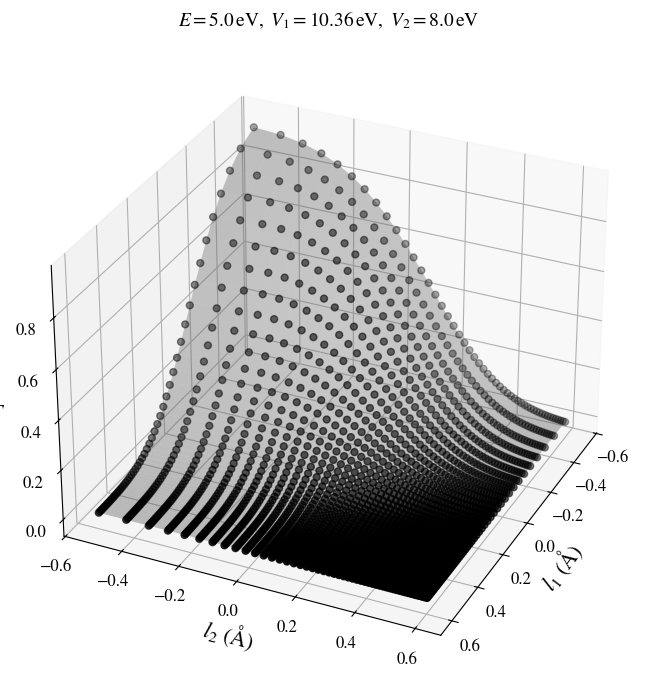

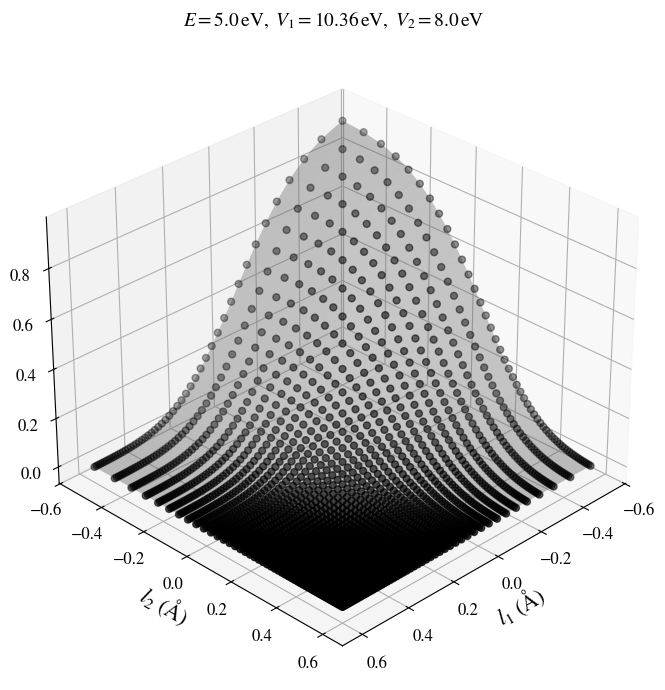

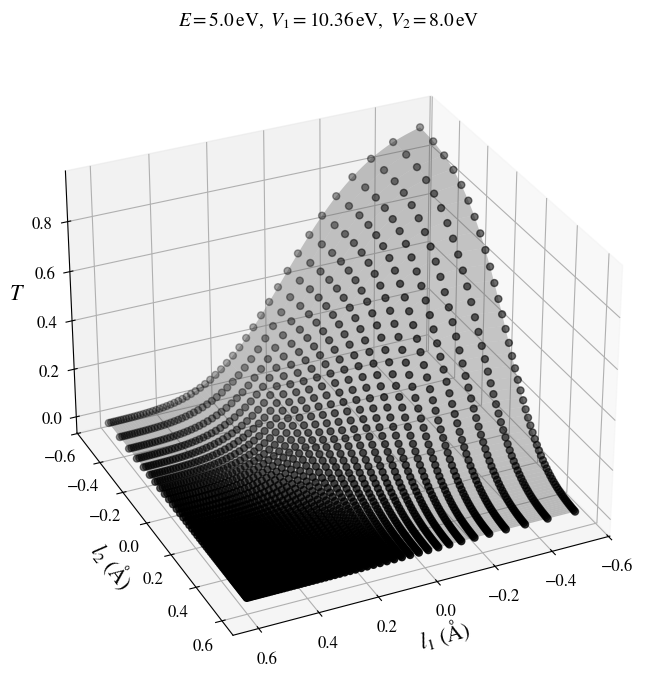

In [5]:
analyze_transmission_surface(
    l1_range=(0.3, 4),  
    l2_range=(0.3, 4),
    Nsurf=200,
    N_grid= 50
    )

In [39]:
def analyze_transmission_heatmap(
    E_eV=5.0,                 # Incident energy (eV)
    V1_eV=10.36,
    V2_eV=8.0,
    d_ang=1.0,                # Well width (Å)
    l1_range=(0.3, 0.8),      # Å
    l2_range=(0.4, 1.2),      # Å
    N_grid=12,                # Raw grid resolution
    Nsurf=200,                # Surface resolution
    cmap="viridis",           # <<< CHANGE COLOR SCHEME HERE
    n_contours=12
):
    # ----------------------------------------------------
    # 1. Length grids (Å → m)
    # ----------------------------------------------------
    l1_vals_ang = np.linspace(*l1_range, N_grid)
    l2_vals_ang = np.linspace(*l2_range, N_grid)

    l1_vals = l1_vals_ang * 1e-10
    l2_vals = l2_vals_ang * 1e-10
    d_m = d_ang * 1e-10

    L1_grid, L2_grid = np.meshgrid(l1_vals_ang, l2_vals_ang, indexing="ij")

    # ----------------------------------------------------
    # 2. Compute transmission on raw grid
    # ----------------------------------------------------
    T_raw = np.zeros_like(L1_grid)

    for i, l1 in enumerate(l1_vals):
        for j, l2 in enumerate(l2_vals):
            T_raw[i, j] = T_double_barrier_asym(
                E_eV=np.array([E_eV]),
                V1_eV=V1_eV,
                l1_m=l1,
                V2_eV=V2_eV,
                l2_m=l2,
                d_m=d_m
            )[0]

    # ----------------------------------------------------
    # 3. Fine grid (interpolation)
    # ----------------------------------------------------
    l1_fine = np.logspace(
        np.log10(l1_vals_ang.min()),
        np.log10(l1_vals_ang.max()),
        Nsurf
    )
    l2_fine = np.logspace(
        np.log10(l2_vals_ang.min()),
        np.log10(l2_vals_ang.max()),
        Nsurf
    )

    L1_fine, L2_fine = np.meshgrid(l1_fine, l2_fine, indexing="ij")

    points = np.column_stack([L1_grid.flatten(), L2_grid.flatten()])
    values = T_raw.flatten()

    T_surf = griddata(
        points, values,
        (L1_fine, L2_fine),
        method="cubic"
    )

    mask = np.isnan(T_surf)
    if np.any(mask):
        T_surf[mask] = griddata(
            points, values,
            (L1_fine[mask], L2_fine[mask]),
            method="linear"
        )

    # ----------------------------------------------------
    # 4. Plot heat map + contours
    # ----------------------------------------------------
    plt.rcParams["font.family"] = "STIXGeneral"
    plt.rcParams["mathtext.fontset"] = "stix"

    fig, ax = plt.subplots(figsize=(10, 7.5))

    # Heat map
    pcm = ax.pcolormesh(
        L1_fine, L2_fine, T_surf,
        shading="auto",
        cmap=cmap
    )

    # Contours
    cs = ax.contour(
        L1_fine, L2_fine, T_surf,
        levels=n_contours,
        colors="k",
        linewidths=1    )
    
    #ax.clabel(cs, fontsize=13, inline=True)

    # Logarithmic axes (TRUE log scale)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.invert_yaxis()
    ax.invert_xaxis()

    # Labels
    ax.set_xlabel(r"$\text{Barrier width} \ (a_{1})\mathrm{(\AA)}$", fontsize=22)
    ax.set_ylabel(r"$\text{Barrier width} \ (a_{2})\mathrm{(\AA)}$", fontsize=22)


    # Colorbar
    cbar = fig.colorbar(pcm, ax=ax, pad=0.02, )
    cbar.set_label(r"$T$", fontsize=20)
    cbar.ax.tick_params(labelsize=18)

  
    ax.tick_params(axis="both", which="major", labelsize=18, length=6, size = 8)
    ax.tick_params(axis="both", which="minor", length=4, labelsize = 16 )
    plt.tight_layout()
    plt.savefig("QuantumHeatmap.pdf")
    plt.show()


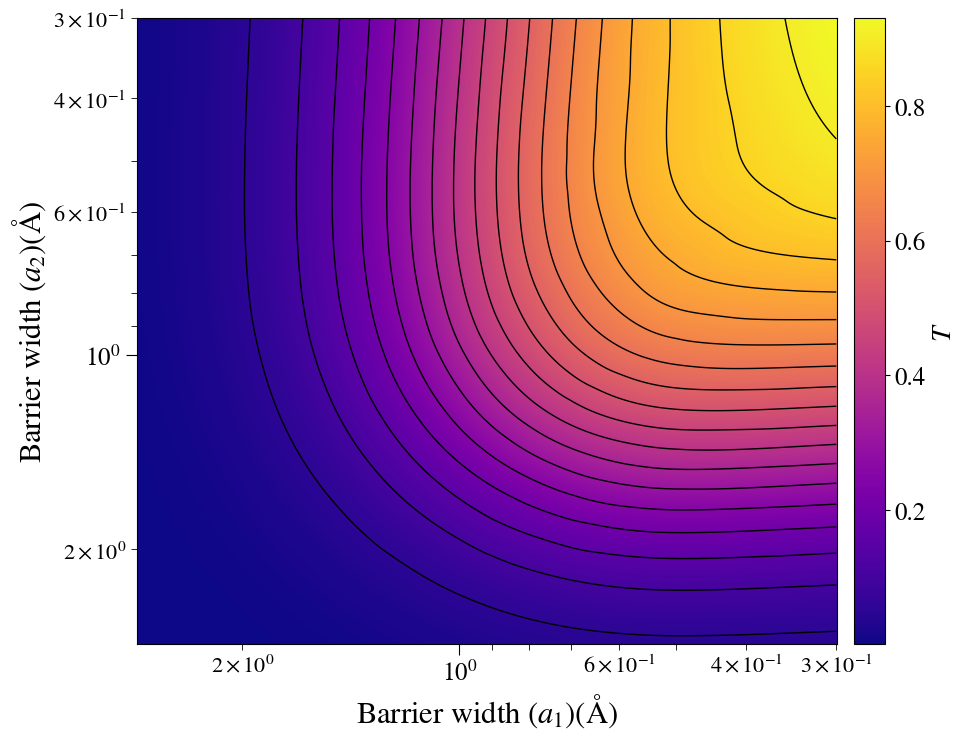

In [40]:
analyze_transmission_heatmap(l1_range=(0.3,2.8),  
    l2_range=(0.3, 2.8),
    Nsurf=1000, n_contours=20, cmap="plasma")